In [1]:
import gym
import gym.spaces
import numpy as np
from qiskit.circuit.library import *
from scipy.interpolate import interp1d
from qiskit.quantum_info import average_gate_fidelity
from stable_baselines3.common.policies import ActorCriticPolicy, ActorCriticCnnPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import PPO
from stable_baselines3.a2c import A2C
from stable_baselines3.common.utils import set_random_seed
from qiskit.quantum_info import Operator
from qiskit.circuit import QuantumCircuit

2024-03-22 23:39:17.919983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 23:39:18.956242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def apply_single_qubit_gate(qubits, gate, i):
    out_gate = 1
    # apply the single qubit gate to the ith qubit
    for j in range(qubits):
        if j == i:
            out_gate = np.kron(out_gate, gate.to_matrix())
        else:
            out_gate = np.kron(out_gate, IGate().to_matrix())

    return out_gate

In [3]:
apply_single_qubit_gate(2, XGate(), 1)

array([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [4]:
gate = apply_single_qubit_gate(3, HGate(), 1)
print(gate.shape)

(8, 8)


In [4]:
def apply_cnot_gate(qubits, i, j):
    out_1, out_2 = 1, 1
    # apply the cnot gate between the ith and jth qubits
    # ith qubit is the control qubit and jth qubit is the target qubit
    for k in range(qubits):
        if k == i:
            out_1 = np.kron(out_1, np.array([[1, 0], [0, 0]]))
            out_2 = np.kron(out_2, np.array([[0, 0], [0, 1]]))
        elif k == j:
            out_1 = np.kron(out_1, IGate().to_matrix())
            out_2 = np.kron(out_2, XGate().to_matrix())
        else:
            out_1 = np.kron(out_1, IGate().to_matrix())
            out_2 = np.kron(out_2, IGate().to_matrix())

    return out_1 + out_2

In [6]:
cnot_gate = apply_cnot_gate(2, 0, 1)
print(gate.shape)

(8, 8)


In [7]:
cnot_gate @ [0, 0, 0, 1] == [0, 0, 1, 0]

array([ True,  True,  True,  True])

In [8]:
print(CXGate().name)

cx


In [9]:
print(PhaseGate(np.pi / 4).name)

p


In [5]:
angles = np.linspace(0.0, 2 * np.pi, 8)
# RX_GATES = [RXGate(theta) for theta in angles]
# RY_GATES = [RYGate(theta) for theta in angles]
PHASE_GATES = [PhaseGate(np.pi * 2 * r / 8, label=f"p(pi/{r})") for r in range(8)]
SINGLE_GATES = [
    HGate(),
    TGate(),
    # TdgGate(),
]
TWO_QUBIT_GATES = [CXGate()]

In [6]:
class GateSynthesisEnv(gym.Env):
    def __init__(self, actions, goal, gamma=0.9, max_steps=25):
        self.interp = interp1d([-1.001, 1.001], [0, 2**6])
        # goal is a matrix representation of the gate, its size decides the number of qubits
        self.goal = goal
        # discount factor
        self.gamma = gamma
        # identify the observation and action spaces
        # a state is (2^n) x (2^n) x 2
        # dim 2 for real and image parts of the complex numbers
        self.observation_space = gym.spaces.Box(
            low=0, high=2**6, shape=(*goal.shape, 2), dtype=float
        )
        self._actions = actions
        self.action_space = gym.spaces.Discrete(len(actions))
        self._states = np.identity(goal.shape[0], dtype=complex)
        # print("init states", self._states)
        self.state = self.interp(
            np.stack([self._states.real, self._states.imag], axis=-1)
        )
        self.program = []
        self.current_step = 0
        self.max_steps = max_steps
        self.info = {}

    def step(self, action):
        gate = self._actions[action]
        # print(gate)
        # print(gate["matrix"].shape)
        # print("before gate", self._states.shape)
        self._states = gate["matrix"] @ self._states
        self.state = self.interp(
            np.stack([self._states.real, self._states.imag], axis=-1)
        )
        # print("interpolated states", self.state)
        self.program.append(gate)
        self.current_step += 1
        # print("reward", states.T.conj() * self.goal_states)

        reward = average_gate_fidelity(
            Operator(self._states), target=Operator(self.goal)
        )
        if reward > 0.98:
            done = True
            reward = 1
        elif self.current_step >= self.max_steps:
            done = True
        else:
            done = False
            reward = 0

        return self.state, reward, done, self.info

    def reset(self):
        self.program = []
        states = np.identity(self.goal.shape[0])
        self.state = self.interp(np.stack([states.real, states.imag], axis=-1))
        self.current_step = 0
        self._states = states

        return self.state

In [16]:
set_random_seed(14)


class MultiGateSynthesizer:
    def __init__(self, circuit, lr=3e-4, model="ppo", ent_coef=1e-5):
        self.qubits = circuit.num_qubits
        gates = [
            {
                "name": "I",
                "matrix": np.identity(2**self.qubits),
            }
        ]
        for gate in SINGLE_GATES:
            for i in range(self.qubits):
                gates.append(
                    {
                        "name": f"{gate.name if gate.label is None else gate.label}({i})",
                        "matrix": apply_single_qubit_gate(self.qubits, gate, i),
                    }
                )
        for i in range(self.qubits):
            for j in range(self.qubits):
                if i != j:
                    gates.append(
                        {
                            "name": f"cnot({i},{j})",
                            "matrix": apply_cnot_gate(self.qubits, i, j),
                        }
                    )

        self.env = GateSynthesisEnv(gates, Operator(circuit).data)

        if model == "ppo":
            self.model = PPO(
                ActorCriticPolicy,
                self.env,
                learning_rate=lr,
                ent_coef=ent_coef,
                verbose=1,
                tensorboard_log="./circuit_rl_tensorboard/",
            )
        else:
            self.model = A2C(ActorCriticPolicy, self.env, verbose=1)

    def solve(self, max_steps):
        self.model.learn(total_timesteps=max_steps)

    def check(self):
        done = False
        obs = self.env.reset()
        program = []

        while not done:
            optimal_action, _ = self.model.predict(obs)
            program.append(self.env._actions[optimal_action])
            obs, rewards, done, info = self.env.step(optimal_action)

        print("Found synthesis result:")
        for ac in program:
            print(ac["name"])

        return program

In [8]:
def check_result(program, target_circuit):
    gate = program[0]["matrix"]
    for ac in program[1:]:
        gate = ac["matrix"] @ gate

    goal_gate = Operator(target_circuit).data
    assert np.allclose(gate, goal_gate)

In [16]:
# (HT)^n
programs = []
target_circuit = QuantumCircuit(1)
for _ in range(10):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(50000)
program = synthesizer.check()
programs.append(program)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_199
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.519    |
| time/              |          |
|    fps             | 1593     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.469       |
| time/                   |             |
|    fps                  | 1270        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012711537 |
|    clip_fraction        | 0.109       |
|    clip_range   

In [17]:
check_result(program, target_circuit)

AssertionError: 

In [45]:
# (HT)^n
target_circuit = QuantumCircuit(1)
for _ in range(10**2):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(60000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_210


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.421    |
| time/              |          |
|    fps             | 1646     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.528       |
| time/                   |             |
|    fps                  | 1288        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009890697 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -3.48       |
|    learning_rate        | 0.

In [46]:
check_result(program, target_circuit)

AssertionError: 

In [48]:
# (HT)^n
programs = []
target_circuit = QuantumCircuit(1)
for _ in range(10**3):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_211


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 0.541    |
| time/              |          |
|    fps             | 1655     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.524       |
| time/                   |             |
|    fps                  | 1289        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011192847 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -4.47       |
|    learning_rate        | 0.

In [50]:
gate = program[0]["matrix"]
for ac in program[1:]:
    gate = ac["matrix"] @ gate

goal_gate = Operator(target_circuit).data

from qiskit.quantum_info import DensityMatrix, state_fidelity

print(gate)
print(goal_gate)
print(average_gate_fidelity(Operator(gate), target=Operator(goal_gate)))
print(
    state_fidelity(
        DensityMatrix(gate @ np.array([1, 0])),
        DensityMatrix(goal_gate @ np.array([1, 0])),
    )
)

[[0.85355339+0.35355339j 0.35355339-0.14644661j]
 [0.14644661-0.35355339j 0.35355339+0.85355339j]]
[[ 0.76764181-0.43489951j  0.18014128-0.43489951j]
 [-0.18014128-0.43489951j  0.76764181+0.43489951j]]
0.9855785048001575
0.9883293122767918


In [51]:
# (HT)^n
programs = []
target_circuit = QuantumCircuit(1)
for _ in range(10**4):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_212


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.384    |
| time/              |          |
|    fps             | 1613     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.2        |
|    ep_rew_mean          | 0.606       |
| time/                   |             |
|    fps                  | 1289        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008466482 |
|    clip_fraction        | 0.0595      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -3.36       |
|    learning_rate        | 0.

In [53]:
gate = program[0]["matrix"]
for ac in program[1:]:
    gate = ac["matrix"] @ gate

goal_gate = Operator(target_circuit).data

from qiskit.quantum_info import DensityMatrix, state_fidelity

print(gate)
print(goal_gate)
print(average_gate_fidelity(Operator(gate), target=Operator(goal_gate)))
print(
    state_fidelity(
        DensityMatrix(gate @ np.array([1, 0])),
        DensityMatrix(goal_gate @ np.array([1, 0])),
    )
)

[[0.85355339+0.35355339j 0.35355339-0.14644661j]
 [0.14644661-0.35355339j 0.35355339+0.85355339j]]
[[ 0.78180296-0.42312342j  0.17526346-0.42312342j]
 [-0.17526346-0.42312342j  0.78180296+0.42312342j]]
0.9896018566452982
0.9915852356275634


In [54]:
# (HT)^n
programs = []
target_circuit = QuantumCircuit(1)
for _ in range(10**5):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_213
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.642    |
| time/              |          |
|    fps             | 1603     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.535       |
| time/                   |             |
|    fps                  | 1259        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008694489 |
|    clip_fraction        | 0.0596      |
|    clip_range   

In [55]:
gate = program[0]["matrix"]
for ac in program[1:]:
    gate = ac["matrix"] @ gate

goal_gate = Operator(target_circuit).data

from qiskit.quantum_info import DensityMatrix, state_fidelity

print(gate)
print(goal_gate)
print(average_gate_fidelity(Operator(gate), target=Operator(goal_gate)))
print(
    state_fidelity(
        DensityMatrix(gate @ np.array([1, 0])),
        DensityMatrix(goal_gate @ np.array([1, 0])),
    )
)

[[0.85355339+0.35355339j 0.35355339-0.14644661j]
 [0.14644661-0.35355339j 0.35355339+0.85355339j]]
[[ 0.90077029-0.29471244j  0.12207389-0.29471244j]
 [-0.12207389-0.29471244j  0.90077029+0.29471244j]]
0.9935171841595937
0.9947537395873615


In [56]:
# (HT)^n
programs = []
target_circuit = QuantumCircuit(1)
for _ in range(10**6):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_214
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.444    |
| time/              |          |
|    fps             | 1629     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.65        |
| time/                   |             |
|    fps                  | 1317        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011171812 |
|    clip_fraction        | 0.11        |
|    clip_range   

In [57]:
gate = program[0]["matrix"]
for ac in program[1:]:
    gate = ac["matrix"] @ gate

goal_gate = Operator(target_circuit).data

from qiskit.quantum_info import DensityMatrix, state_fidelity

print(gate)
print(goal_gate)
print(average_gate_fidelity(Operator(gate), target=Operator(goal_gate)))
print(
    state_fidelity(
        DensityMatrix(gate @ np.array([1, 0])),
        DensityMatrix(goal_gate @ np.array([1, 0])),
    )
)

[[ 0.5       +5.00000000e-01j  0.5       +5.00000000e-01j]
 [ 0.70710678+5.55111512e-17j -0.70710678+5.55111512e-17j]]
[[-0.21805877+0.66226831j -0.27432052+0.66226831j]
 [ 0.27432052+0.66226831j -0.21805877-0.66226831j]]
0.9980442633712817
0.9984173074759555


In [58]:
# (HT)^n
programs = []
target_circuit = QuantumCircuit(1)
for _ in range(10**7):
    target_circuit.t(0)
    target_circuit.h(0)
# target_circuit.draw("mpl")

synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

KeyboardInterrupt: 

In [24]:
import random


# generate random circuits
def generate_random_k_qubit(n):
    k = random.randint(3, 8)
    gates = [
        "h",
        "t",
        "tdg",
        "cx",
    ]
    selected_gates = random.choices(gates, k=k)
    for gate in selected_gates:

        i = random.choice(range(n))
        if gate == "cx":
            j = i
            while j == i:
                j = random.choice(range(n))
            print(f"target_circuit.{gate}({i}, {j})")
        else:
            print(f"target_circuit.{gate}({i})")

In [25]:
generate_random_k_qubit(2)

target_circuit.h(1)
target_circuit.cx(1, 0)
target_circuit.t(0)
target_circuit.t(1)
target_circuit.tdag(1)


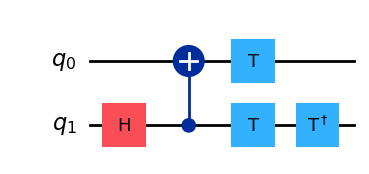

In [10]:
# gen 0
target_circuit = QuantumCircuit(2)
target_circuit.h(1)
target_circuit.cx(1, 0)
target_circuit.t(0)
target_circuit.t(1)
target_circuit.tdg(1)
target_circuit.draw("mpl")

In [19]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(80000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_222
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.294    |
| time/              |          |
|    fps             | 1684     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 25           |
|    ep_rew_mean          | 0.24         |
| time/                   |              |
|    fps                  | 1361         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0053225155 |
|    clip_fraction        | 0.0254       |
|    c

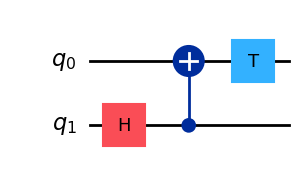

In [21]:
result_circuit = QuantumCircuit(2)
result_circuit.h(1)
result_circuit.cx(1, 0)
result_circuit.t(0)
result_circuit.draw("mpl")

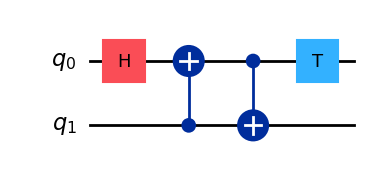

In [23]:
# gen 1
target_circuit = QuantumCircuit(2)
target_circuit.h(0)
target_circuit.cx(1, 0)
target_circuit.cx(0, 1)
target_circuit.t(0)
target_circuit.draw("mpl")

In [25]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_224
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.24     |
| time/              |          |
|    fps             | 1702     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.248       |
| time/                   |             |
|    fps                  | 1334        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008716995 |
|    clip_fraction        | 0.077       |
|    clip_range   

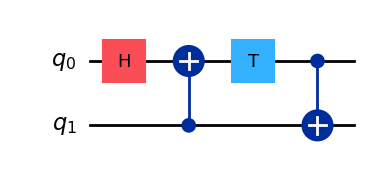

In [26]:
result_circuit = QuantumCircuit(2)
result_circuit.h(0)
result_circuit.cx(1, 0)
result_circuit.t(0)
result_circuit.cx(0, 1)
result_circuit.draw("mpl")

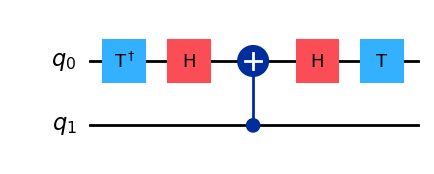

In [27]:
# gen 2
target_circuit = QuantumCircuit(2)
target_circuit.tdg(0)
target_circuit.h(0)
target_circuit.cx(1, 0)
target_circuit.h(0)
target_circuit.t(0)
target_circuit.draw("mpl")

In [28]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_225


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.217    |
| time/              |          |
|    fps             | 1673     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.252       |
| time/                   |             |
|    fps                  | 1347        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008823527 |
|    clip_fraction        | 0.0789      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -1.21       |
|    learning_rate        | 0.

In [29]:
check_result(program, target_circuit)

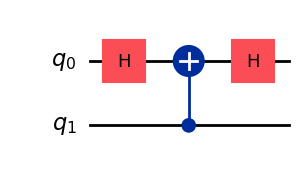

In [30]:
result_circuit = QuantumCircuit(2)
result_circuit.h(0)
result_circuit.cx(1, 0)
result_circuit.h(0)
result_circuit.draw("mpl")

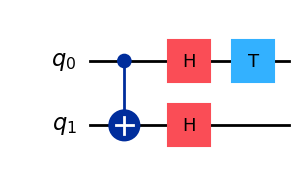

In [31]:
# gen 3
target_circuit = QuantumCircuit(2)
target_circuit.cx(0, 1)
target_circuit.h(0)
target_circuit.t(0)
target_circuit.h(1)
target_circuit.draw("mpl")

In [32]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_226


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.274    |
| time/              |          |
|    fps             | 1671     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.238       |
| time/                   |             |
|    fps                  | 1348        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007938173 |
|    clip_fraction        | 0.0723      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -14.5       |
|    learning_rate        | 0.

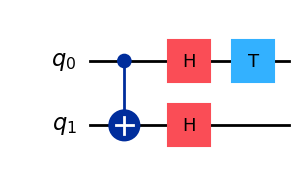

In [33]:
result_circuit = QuantumCircuit(2)
result_circuit.cx(0, 1)
result_circuit.h(1)
result_circuit.h(0)
result_circuit.t(0)
result_circuit.draw("mpl")

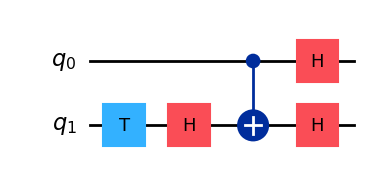

In [36]:
# gen 4
target_circuit = QuantumCircuit(2)
target_circuit.t(1)
target_circuit.h(1)
target_circuit.cx(0, 1)
target_circuit.h(0)
target_circuit.h(1)
target_circuit.draw("mpl")

In [37]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_228


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.254    |
| time/              |          |
|    fps             | 1649     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.269       |
| time/                   |             |
|    fps                  | 1314        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008546166 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -5.73       |
|    learning_rate        | 0.

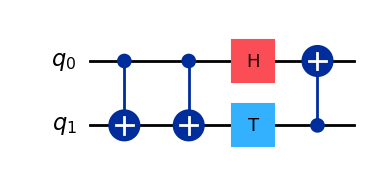

In [39]:
result_circuit = QuantumCircuit(2)
result_circuit.cx(0, 1)
result_circuit.cx(0, 1)
result_circuit.h(0)
result_circuit.t(1)
result_circuit.cx(1, 0)
result_circuit.draw("mpl")

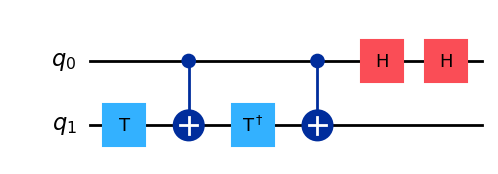

In [40]:
# gen 5
target_circuit = QuantumCircuit(2)
target_circuit.t(1)
target_circuit.cx(0, 1)
target_circuit.tdg(1)
target_circuit.cx(0, 1)
target_circuit.h(0)
target_circuit.h(0)
target_circuit.draw("mpl")

In [42]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(200000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_230
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.268    |
| time/              |          |
|    fps             | 1674     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.239       |
| time/                   |             |
|    fps                  | 1354        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009678153 |
|    clip_fraction        | 0.0649      |
|    clip_range   

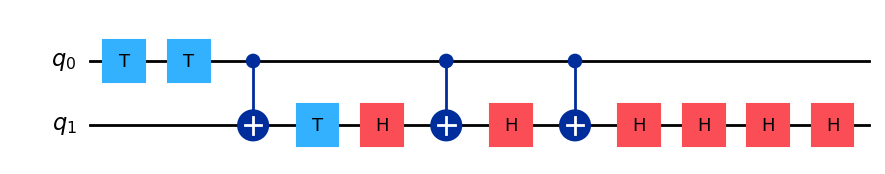

In [45]:
result_circuit = QuantumCircuit(2)
result_circuit.t(0)
result_circuit.t(0)
result_circuit.cx(0, 1)
result_circuit.t(1)
result_circuit.h(1)
result_circuit.cx(0, 1)
result_circuit.h(1)
result_circuit.cx(0, 1)
result_circuit.h(1)
result_circuit.h(1)
result_circuit.h(1)
result_circuit.h(1)
result_circuit.draw("mpl")

In [43]:
gate = program[0]["matrix"]
for ac in program[1:]:
    gate = ac["matrix"] @ gate

goal_gate = Operator(target_circuit).data

from qiskit.quantum_info import DensityMatrix, state_fidelity

print(gate)
print(goal_gate)
print(average_gate_fidelity(Operator(gate), target=Operator(goal_gate)))
print(
    state_fidelity(
        DensityMatrix(gate @ np.array([1, 0])),
        DensityMatrix(goal_gate @ np.array([1, 0])),
    )
)

[[1.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  2.97281036e-17+2.97281036e-17j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 7.07106781e-01-7.07106781e-01j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00-8.90187929e-18j]
 [2.36158002e-17+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  7.07106781e-01+7.07106781e-01j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 1.34692639e-17-1.34692639e-17j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+1.00000000e+00j]]
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678-0.70710678j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.70710678+0.70710678j]]
0.8828427124746181


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [ ]:
# other generations
# gen 6
target_circuit.cx(0, 1)
target_circuit.tdg(0)
target_circuit.t(1)
target_circuit.cx(1, 0)

# gen 7
target_circuit.tdg(1)
target_circuit.h(1)
target_circuit.t(1)
target_circuit.h(0)

# gen 8
target_circuit.tdg(0)
target_circuit.cnot(0, 1)
target_circuit.t(0)
target_circuit.cnot(1, 0)
target_circuit.tdg(1)
target_circuit.cx(0, 1)
target_circuit.cx(1, 0)

# gen 9
target_circuit.tdg(0)
target_circuit.tdg(0)
target_circuit.cx(0)
target_circuit.h(1)
target_circuit.t(1)
target_circuit.t(0)
target_circuit.t(1)
target_circuit.cx(0)

In [36]:
generate_random_k_qubit(3)

target_circuit.cx(0, 2)
target_circuit.h(1)
target_circuit.tdag(1)
target_circuit.t(2)
target_circuit.tdag(2)
target_circuit.tdag(2)


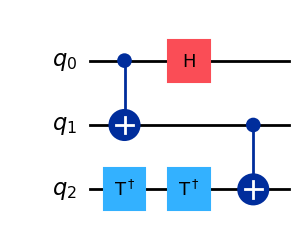

In [46]:
# gen 0
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.tdg(2)
target_circuit.h(0)
target_circuit.tdg(2)
target_circuit.cx(1, 2)
target_circuit.draw("mpl")

In [48]:
synthesizer = MultiGateSynthesizer(target_circuit, lr=1e-2, ent_coef=0)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_232


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.125    |
| time/              |          |
|    fps             | 1676     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.118       |
| time/                   |             |
|    fps                  | 1346        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.045510046 |
|    clip_fraction        | 0.587       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | -22.9       |
|    learning_rate        | 0.

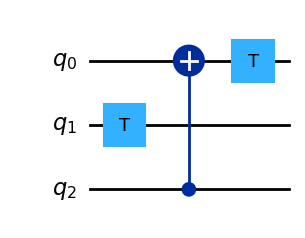

In [51]:
# gen 1
target_circuit = QuantumCircuit(3)
target_circuit.t(1)
target_circuit.cx(2, 0)
target_circuit.t(0)
target_circuit.draw("mpl")

In [52]:
synthesizer = MultiGateSynthesizer(target_circuit, ent_coef=0)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_234


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.133    |
| time/              |          |
|    fps             | 1683     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.135       |
| time/                   |             |
|    fps                  | 1342        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007577575 |
|    clip_fraction        | 0.0661      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.56       |
|    explained_variance   | -2.6        |
|    learning_rate        | 0.

In [ ]:
# gen 1
target_circuit.h(0)
target_circuit.h(0)
target_circuit.h(2)
target_circuit.tdg(1)
target_circuit.h(2)
target_circuit.tdg(0)
target_circuit.tdg(1)
target_circuit.cx(2, 1)

# gen 2
target_circuit.tdg(0)
target_circuit.t(1)
target_circuit.h(0)
target_circuit.tdg(1)
target_circuit.cx(1, 0)

# gen 3
target_circuit.cx(0, 2)
target_circuit.tdg(0)
target_circuit.tdg(2)
target_circuit.t(2)
target_circuit.t(1)
target_circuit.cx(2, 1)
target_circuit.cx(0, 2)
target_circuit.h(2)

# gen 4
target_circuit.cx(2, 0)
target_circuit.t(1)
target_circuit.cx(2, 0)
target_circuit.t(1)
target_circuit.t(1)
target_circuit.cx(2, 1)
target_circuit.cx(0, 2)
target_circuit.cx(1, 2)

# gen 5
target_circuit.h(1)
target_circuit.tdg(2)
target_circuit.cx(1, 2)
target_circuit.tdg(0)

# gen 6
target_circuit.h(2)
target_circuit.t(2)
target_circuit.h(2)
target_circuit.cx(2, 1)
target_circuit.h(2)
target_circuit.t(1)

# gen 7
target_circuit.h(2)
target_circuit.tdg(1)
target_circuit.h(2)
target_circuit.t(0)
target_circuit.tdg(0)
target_circuit.tdg(2)

# gen 8
target_circuit.tdg(1)
target_circuit.cx(2, 0)
target_circuit.tdg(0)

# gen 9
target_circuit.cx(0, 2)
target_circuit.h(1)
target_circuit.tdg(1)
target_circuit.t(2)
target_circuit.tdg(2)
target_circuit.tdg(2)

In [6]:
# Bell state
target_circuit = QuantumCircuit(2)
target_circuit.h(0)
target_circuit.cx(0, 1)
target_circuit.draw("mpl")

NameError: name 'QuantumCircuit' is not defined

In [125]:
synthesizer = MultiGateSynthesizer(target_circuit, model="a2c")
synthesizer.solve(10000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 25       |
|    ep_rew_mean        | 0.262    |
| time/                 |          |
|    fps                | 932      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.91    |
|    explained_variance | -111     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.093   |
|    value_loss         | 0.00404  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 25       |
|    ep_rew_mean        | 0.294    |
| time/                 |          |
|    fps                | 950      |
|    iterations         | 200      |
|    time_elapsed 

In [126]:
check_result(program, target_circuit)

In [127]:
# swap gate
target_circuit = QuantumCircuit(2)
target_circuit.swap(0, 1)
target_circuit.draw()

q_0: ─X─
      │ 
q_1: ─X─

In [133]:
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(50000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_195


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.257    |
| time/              |          |
|    fps             | 1628     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.237       |
| time/                   |             |
|    fps                  | 1298        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010040775 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -2.3        |
|    learning_rate        | 0.

In [41]:
check_result(program, target_circuit)

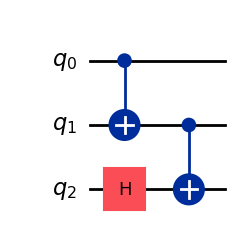

In [42]:
# Random 3-qubit gate with three steps
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.h(2)
target_circuit.cx(1, 2)
target_circuit.draw("mpl")

In [43]:
set_random_seed(111)
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(60000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_169
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.119    |
| time/              |          |
|    fps             | 1669     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.126       |
| time/                   |             |
|    fps                  | 1340        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009431006 |
|    clip_fraction        | 0.0836      |
|    clip_range   

In [44]:
check_result(program, target_circuit)

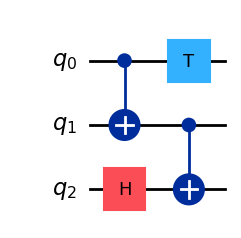

In [45]:
# Random 3-qubit gate with three steps
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.h(2)
target_circuit.cx(1, 2)
target_circuit.t(0)
target_circuit.draw("mpl")

In [48]:
set_random_seed(111)
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(100000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_171
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.122    |
| time/              |          |
|    fps             | 1674     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.131       |
| time/                   |             |
|    fps                  | 1343        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008313979 |
|    clip_fraction        | 0.0816      |
|    clip_range   

In [49]:
check_result(program, target_circuit)

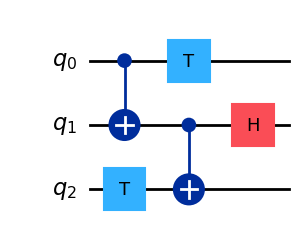

In [108]:
# Random 3-qubit gate
target_circuit = QuantumCircuit(3)
target_circuit.cx(0, 1)
target_circuit.t(2)
target_circuit.cx(1, 2)
target_circuit.t(0)
target_circuit.h(1)
target_circuit.draw("mpl")

In [110]:
set_random_seed(111)
synthesizer = MultiGateSynthesizer(target_circuit)
synthesizer.solve(250000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_190


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.123    |
| time/              |          |
|    fps             | 1644     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.121       |
| time/                   |             |
|    fps                  | 1339        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008265775 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -1.99       |
|    learning_rate        | 0.

In [111]:
check_result(program, target_circuit)

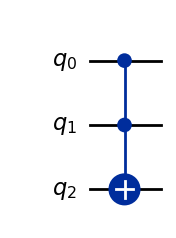

In [136]:
# Toffli gate
target_circuit = QuantumCircuit(3)
target_circuit.ccx(0, 1, 2)
target_circuit.draw("mpl")

In [138]:
def linear_schedule(initial_value):
    """
    Linear learning rate schedule.
    :param initial_value: (float or str)
    :return: (function)
    """
    if isinstance(initial_value, str):
        initial_value = float(initial_value)

    def func(progress):
        """
        Progress will decrease from 1 (beginning) to 0
        :param progress: (float)
        :return: (float)
        """
        return progress * initial_value

    return func


synthesizer = MultiGateSynthesizer(target_circuit, lr=1e-4, ent_coef=5e-4)
synthesizer.solve(500000)
program = synthesizer.check()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./circuit_rl_tensorboard/PPO_198


/home/zheng/anaconda3/envs/circuit_rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.143    |
| time/              |          |
|    fps             | 1679     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.138       |
| time/                   |             |
|    fps                  | 1347        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006471907 |
|    clip_fraction        | 0.0155      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -15.4       |
|    learning_rate        | 0.